# Continuous Wave

In [2]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import numpy as np
import matplotlib
# matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters
import pymc
import seaborn
from scipy.stats import norm
from scipy.signal import savgol_filter
from scipy.fftpack import fft, rfft, fftshift
import pickle
import time as datetime
import pandas

import heralded_pulses_analysis as hpa
import pulse_averaging_cw as pacw
import pulse_fit_v05 as pf
import pulse_fit_v07 as pf7
import single_photon_model_no_shift as noshift
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import thres
import stats_proc as sp

# Single Photon Model

### Step 1a) Calculate Height Thresholds or...

In [3]:
# Imports CW traces
directories = ['/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more_more/']
results_directory = './'
filelist=[]
for directory_name in directories:
    subfilelist = np.array(glob.glob(directory_name + '*.trc'))
    filelist.extend(subfilelist)
filelist = np.array(filelist)
# filelist = np.flipud(np.sort(filelist))
filelist = np.sort(filelist)
print(filelist[0:2])
print len(filelist)

[ '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00000.trc'
 '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00001.trc']
400000


In [4]:
# Set left and right time limits of each trace to process
t_initial = None
t_final = None
height_th = 0.072 #to be updated with pt of minimal overlap between n=0 and n=1 distributions
t0 = 0.5e-6

<IPython.core.display.Javascript object>


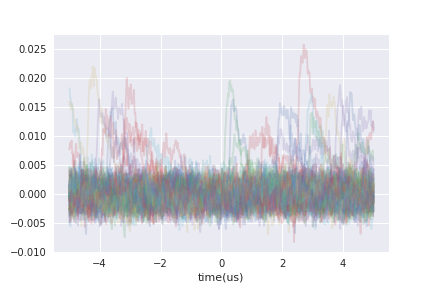

In [177]:
# Performs an initial plot
%matplotlib notebook
reload(hpa)
hpa.pplot(filelist[:1000], height_th, t_initial, t_final)
# plt.ylim(0,0.02)
# plt.plot(time_f*1e6+0.3,2*signal_f)

In [149]:
# Extract SOME trace properties, just to generate height threshold (first pass)
reload(hpa)
data = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [00:14<00:00, 711.92it/s]


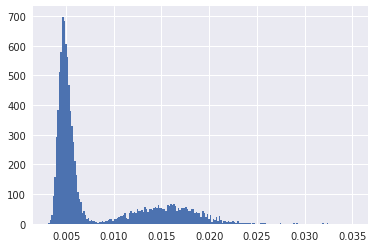

In [151]:
heights = data['height']
pnr_height = np.histogram(heights, 200)
np.savetxt(results_directory+'heights_cw_derived_single_diode_pulse.dat', heights)
%matplotlib inline
plt.figure()
plt.hist(heights,200);

In [152]:
# Detect valleys separating peaks or...
th = thres_poiss.thresholds_N(pnr_height, min_peak_sep=0.01, weighted=True)
np.savetxt(results_directory+'height_thresholds_cw_derived_single_diode_pulse.dat',th)
print th

[(0.0093566880499345341, 0.0054771774245399221, 1.5912567816522838e-05)]


### Step 1b) or.. load threshold file if exists

In [6]:
th = np.loadtxt(results_directory+'height_thresholds_cw_derived_single_diode_pulse.dat')
print th

[  9.35668805e-03   5.47717742e-03   1.59125678e-05]


[ 0.0041726  0.0048918  0.0051026 ...,  0.005518   0.012338   0.0042904]


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


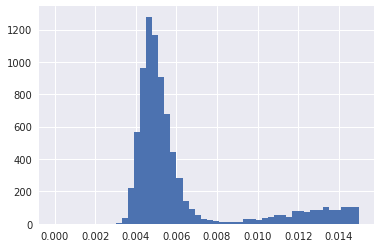

In [4]:
heights = np.loadtxt(results_directory+'heights_cw_derived_single_diode_pulse.dat')
print heights
%matplotlib inline
plt.figure()
plt.hist(heights,50,range=(0,0.015));

In [157]:
# Noise Amplitude Standard Deviation
(mu0,sigma0) = norm.fit(heights[(heights<th[0])])
print mu0, sigma0, sigma0/mu0

0.00502351047948 0.000806361088342 0.160517449229


In [158]:
# Single Photon Amplitude Standard Deviation
# (mu,sigma) = norm.fit(heights[(heights>th[0][0])&(heights<th[1][0])])
# print mu, sigma, sigma/mu

In [7]:
# Update height threshold, ,reprocess trace parameters
height_th = th[0]
print height_th

0.00935668804993


### Second pass to get better height threshold estimation

In [9]:
# Using the height_th obtained earlier as input to the SET-RESET switch, 
# Process the traces again and extract the max heights on the 'clamped' traces (without partial edge pulses)
reload(pd)
reload(hpa)
data_second_pass = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:10000])])


  5%|▌         | 21561/400000 [01:10<20:29, 307.70it/s]A

100%|██████████| 10000/10000 [00:15<00:00, 662.26it/s]

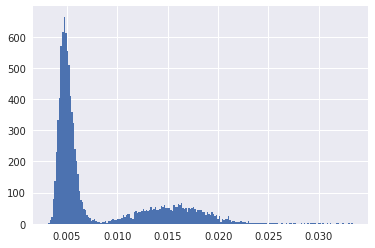

In [10]:
heights_second_pass = data_second_pass['height_clamped']
pnr_height_second_pass = np.histogram(heights_second_pass, 200)
np.savetxt(results_directory+'heights_second_pass_cw_derived_single_diode_pulse.dat', heights_second_pass)
%matplotlib inline
plt.figure()
plt.hist(heights_second_pass,200);

In [11]:
th = thres_poiss.thresholds_N(pnr_height_second_pass, min_peak_sep=0.01, weighted=True)
np.savetxt(results_directory+'height_thresholds_second_pass_cw_derived_single_diode_pulse.dat',th)
print th

[(0.0087910892321664859, 0.0029301104984088577, 2.0385199201555793e-05)]


In [5]:
th = np.loadtxt(results_directory+'height_thresholds_second_pass_cw_derived_single_diode_pulse.dat')
print th

[  8.79108923e-03   2.93011050e-03   2.03851992e-05]


In [6]:
height_th = th[0] #refresh height_th with the threshold obtained from the second pass.

### Step 2a) Calculate Single Photon Model or...
via filtering for n=1 events using height_th obtained earlier

In [250]:
reload(hpa)
data_height_from_cw = np.array([hpa.param_extr(f,t_initial,t_final,height_th,t0)
                 for f
                 in tqdm.tqdm(filelist[:10000])])

100%|██████████| 10000/10000 [00:20<00:00, 483.75it/s]


In [251]:
areas_height_from_cw = data_height_from_cw['area_win']

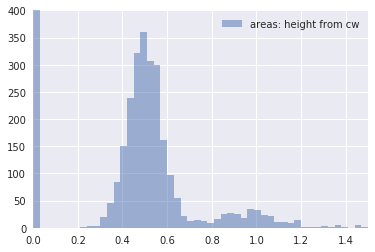

In [252]:
%matplotlib inline
plt.figure()
# plt.hist(areas_height_from_pulsed,100,
#          range=(0,3),
#          alpha=0.5,
#          label='height from pulsed'
#         );
plt.hist(areas_height_from_cw,100,
         range=(0,3),
         alpha=0.5,
         label='areas: height from cw'
        );
plt.legend()
plt.ylim(0,400)
plt.xlim(0,1.5)
plt.show()

In [173]:
pnr_height_from_cw = np.histogram(areas_height_from_cw, 200)
pnr_height_from_cw = [pnr_height_from_cw[0][1:], pnr_height_from_cw[1][1:]]

In [174]:
# Use multi-gaussian fitting algorithm to find centers and sigmas
# Does not assume population is Poisson distributed.
reload(thres)
area_mus, area_sigmas = thres.gauss_fit_results(pnr_height_from_cw,
                                          min_peak_sep=0.3, 
                                          threshold=None, 
                                          weighted=True)
print area_mus, area_sigmas

[ 0.55521278  1.05943   ] [ 0.06640665  0.0942992 ]


In [175]:
th_areas = [(area_mus[i]-2*area_sigmas[i],area_mus[i]+2*area_sigmas[i]) for i,_ in enumerate(area_mus)]
np.savetxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat', th_areas)
print th_areas

[(0.42239948585736209, 0.68802607868179355), (0.87083159863248882, 1.2480283938633678)]


In [7]:
th_areas = np.loadtxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat')
print th_areas

[[ 0.41597328  0.68272336]
 [ 0.81773053  1.29010192]]


In [178]:
# print 'single photon amplitude: truncated distribution for prior' 
# print 'left limit = {}'.format((area_mus[1]-4*area_sigmas[1])/2/area_mus[0])
# print 'center = {}'.format((area_mus[1])/2/area_mus[0])
# print 'sigma = {}'.format((area_sigmas[1])/area_mus[0])
# print 'right limit = {}'.format((area_mus[1]+4*area_sigmas[1])/2/area_mus[0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400000 but corresponding boolean dimension is 10000
  after removing the cwd from sys.path.


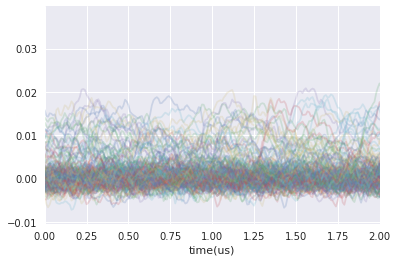

In [179]:
mask_1ph = (areas_height_from_cw>th_areas[0][0])&(areas_height_from_cw<th_areas[0][1])
np.savetxt(results_directory+'mask_1ph_cont_from_cw.dat', mask_1ph)
# reload(hpa)
hpa.pplot(filelist[mask_1ph], height_th)
plt.xlim(0,2);

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400000 but corresponding boolean dimension is 10000
  after removing the cwd from sys.path.


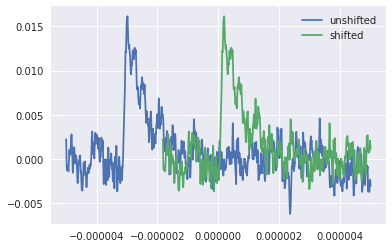

In [180]:
# testing of shifting- to be del after development
reload(hpa)
reload(pacw)
t,s = hpa.trace_extr(filelist[mask_1ph][5])
plt.figure()
plt.plot(t,s,label='unshifted')
plt.plot(t,pacw.time_offset(t,s),label='shifted')
plt.legend()
plt.show()

In [181]:
# Generate average pulse with horizontal offset correction
reload(pacw)
time_p, signal_p = pacw.trace_ave(filelist[:10000][mask_1ph], t_initial, t_final)

# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

/usr/local/lib/python2.7/dist-packages/peakutils/peak.py:216: UserWarning: At least 3 points required for Gaussian fitting
  warnings.warn(str(e))
/usr/local/lib/python2.7/dist-packages/peakutils/peak.py:216: UserWarning: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
  warnings.warn(str(e))


In [182]:
# Use model to generate another model that has horizontal offset correction
reload(pacw)
time_f, signal_f, sigma_f = pacw.fit_corrected_pulse(filelist[:10000][mask_1ph], 
                                                   fit_model,
                                                   t_initial,
                                                   t_final)

<Container object of 3 artists>

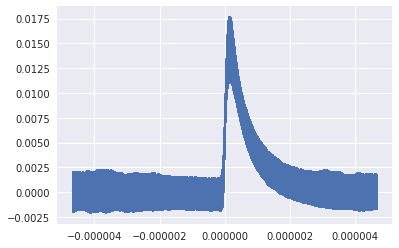

In [183]:
plt.figure()
plt.errorbar(time_f, signal_f, sigma_f)

[]

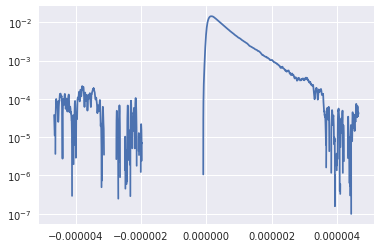

In [185]:
# plots single photon model in semilog axis to check vertical offset correction 
%matplotlib inline
plt.figure()
plt.plot(time_f,signal_f)
plt.semilogy()

In [186]:
np.save(results_directory + 'ph1_model_from_cw.npy',
            np.array(zip(time_f, signal_f, sigma_f)))

### Step 2b) or... Load Single Photon Model

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


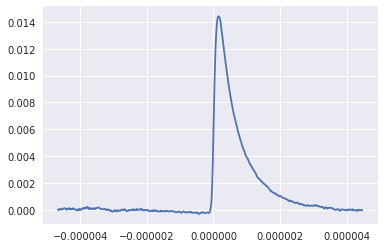

In [8]:
# Loads Single Photon Model
%matplotlib inline
ph1_model = np.load(results_directory + 'ph1_model_from_cw.npy')
plt.figure()
time_f, signal_f = ph1_model[:,0], ph1_model[:,1]
time_f, signal_f = time_f[:-100], signal_f[:-100]
plt.plot(time_f,signal_f)
# plt.xlim(-200e-9,600e-9)

In [256]:
def rise_time(time,signal,plot=True):
    """returns 10% to 90% rise timing"""
    amplitude = np.max(signal)
    idxpeak = np.argmax(signal)
    def find_idx(array,value):
        array=np.array(array)
        return np.argmin(np.abs(array-value))
    t10 = time[find_idx(signal[:idxpeak],0.1*amplitude)]
    t90 = time[find_idx(signal[:idxpeak],0.9*amplitude)]
    risetime = t90-t10
    if plot:
        plt.figure()
        plt.plot(time,signal)
        plt.axvline(t10,linestyle='--')
        plt.axvline(t90,linestyle='--')
    return risetime

121.99999655


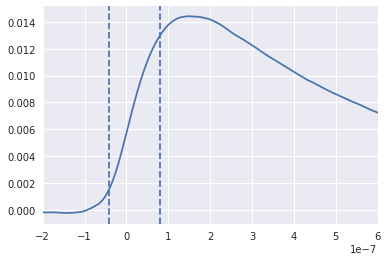

In [257]:
print rise_time(time_f,signal_f)*1e9
# print rise_time(time_p,signal_p)*1e9
plt.xlim(-200e-9,600e-9);

width at height_th = 2.27799993557us


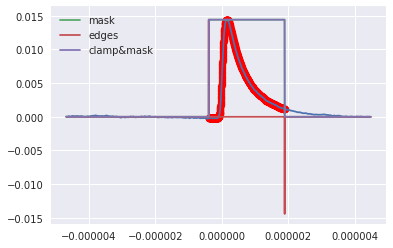

In [15]:
# "Width" of average single photon pulse: 
# Use this to determine the average trace length = 10 us - width
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(time_f, signal_f, dt_left=300e-9,dt_right=1400e-9, height_th=height_th, Plot=True, method=2)
print('width at height_th = {}us'
    .format(1e6*(time_f[right_edges[0]]-time_f[left_edges[0]])))

# Fit to 2 photon traces

### Step 3: Import all CW traces
if you haven't already, and perform filtering on them...

In [9]:
# Imports double diode excitation traces
filelist_cont=filelist
# filelist_cont = np.flipud(np.sort(filelist_cont))
print(filelist_cont[:2])
len(filelist_cont)

[ '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00000.trc'
 '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00001.trc']


400000

In [17]:
reload(hpa)
data_cont = np.array([hpa.param_extr(f, t_initial, t_final, h_th=height_th)
                 for f
                 in tqdm.tqdm(filelist_cont[:])])
# data_cont=data

100%|██████████| 400000/400000 [16:28<00:00, 404.65it/s]


In [18]:
# Generate Area histograms
areas_height_from_cw = data_cont['area_win']
np.savetxt(results_directory+'areas_height_from_cw.dat',areas_height_from_cw)

In [10]:
# Or Load...
areas_height_from_cw = np.loadtxt(results_directory+'areas_height_from_cw.dat')

In [11]:
# use the area to count the number of photons
pnr_height_from_cw = np.histogram(areas_height_from_cw, 200)
# remove the first bin that is not gaussian, and will affect the threshold detection algorithm
pnr_height_from_cw = [pnr_height_from_cw[0][1:], pnr_height_from_cw[1][1:]]

(0, 1000)

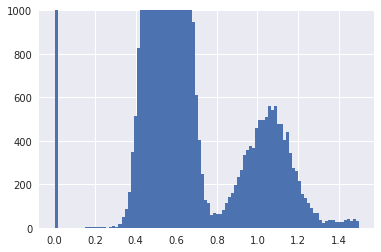

In [21]:
%matplotlib inline
plt.figure()
plt.hist(areas_height_from_cw,100,
         range=(0,1.5)
        );
# plt.semilogy()
plt.ylim(0,1000)
# plt.xlim(0.6,1)

In [22]:
# Find Centers and Sigmas of distributions
# does not assume population is Poisson distributed.
reload(thres)
area_mus, area_sigmas = thres.gauss_fit_results(pnr_height_from_cw,
                                          min_peak_sep=0.3, 
                                          threshold=None, 
                                          weighted=True)
np.savetxt(results_directory+'area_mus.dat',area_mus)
np.savetxt(results_directory+'area_sigmas.dat',area_sigmas)
print area_mus, area_sigmas

[ 0.54934832  1.05391623] [ 0.06668752  0.11809285]


In [23]:
# Generate Area Thresholds
th_areas = [(area_mus[i]-2*area_sigmas[i],area_mus[i]+2*area_sigmas[i]) for i,_ in enumerate(area_mus)]
np.savetxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat', th_areas)
print th_areas

[(0.41597328359253183, 0.68272336486205898), (0.81773053415125307, 1.2901019186750755)]


In [12]:
# Or Load Centers, Sigmas and Area Thresholds 
area_mus = np.loadtxt(results_directory+'area_mus.dat')
area_sigmas = np.loadtxt(results_directory+'area_sigmas.dat')
th_areas = np.loadtxt(results_directory+'area_thresholds_single_diode_pulse_from_cw.dat')
print th_areas

[[ 0.41597328  0.68272336]
 [ 0.81773053  1.29010192]]


In [200]:
# print 'single photon amplitude: truncated distribution for prior' 
# print 'left limit = {}'.format((area_mus[1]-4*area_sigmas[1])/2/area_mus[0])
# print 'center = {}'.format((area_mus[1])/2/area_mus[0])
# print 'sigma = {}'.format((area_sigmas[1])/area_mus[0])
# print 'right limit = {}'.format((area_mus[1]+4*area_sigmas[1])/2/area_mus[0])

In [25]:
# Calculate overlap of Area Distribution between n=1 and n=2 traces.
from scipy.special import erf
def inside_prob(x,x0,sig0):
    "prob that data lies from -x to x"
    return erf((x-x0)/sig0/np.sqrt(2))
print 'dark count probability = {}%'.format((1-inside_prob(th_areas[1][0],area_mus[0],area_sigmas[0]))/2*100)
print 'efficiency = {}'.format((inside_prob(th_areas[1][0],area_mus[1],area_sigmas[1]))*100)

dark count probability = 0.00285513677888%
efficiency = -95.4499736104


In [26]:
plt.savefig(results_directory+'area_windowed_dtleft_200ns_dtright_700ns.pdf')

### Step 4a: Select 2-photon traces, or load

In [27]:
mask_2ph_cont = (areas_height_from_cw>th_areas[1][0])&(areas_height_from_cw<th_areas[1][1])
np.savetxt(results_directory+'mask_2ph_cont.dat', mask_2ph_cont)

In [17]:
mask_2ph_cont = np.loadtxt(results_directory+'mask_2ph_cont.dat').astype(bool)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


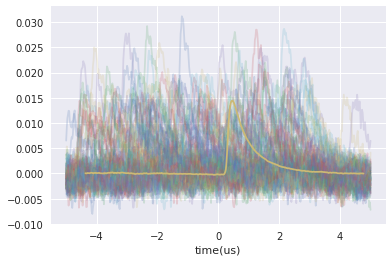

In [29]:
# Plots 2 Photons traces as a check
%matplotlib inline
plt.figure()
hpa.pplot(filelist_cont[mask_2ph_cont][0:1000], height_th, plot_every=10)
# plt.plot(time_f*1e6,signal_f, label='single photon model')
plt.legend()
# plt.xlim(0,1.5);
plt.plot(time_f*1e6+0.3, signal_f)
# plt.savefig(results_directory+'persist_cont.pdf')

### Define Priors for MCMC

In [14]:
# define amplitude distribution parameters
amp_mu = 1 #area_mus[1]/area_mus[0]/2
amp_tau = 1/((area_sigmas[0]/area_mus[0])**2)
amp_a = th_areas[0][0]/area_mus[0]
amp_b = th_areas[0][1]/area_mus[0]
print amp_mu, amp_tau, amp_a, amp_b

1 67.8588460196 0.757212255408 1.24278774459


In [30]:
# define amplitude sum distribution as n=2 area distribution normalised to n=1 mean area
# sum_mu = area_mus[1]/area_mus[0]
# sum_tau = 1.0/((area_sigmas[1]/area_mus[0])**2)
# sum_a = th_areas[1][0]/area_mus[0]
# sum_b = th_areas[1][1]/area_mus[0]

In [31]:
# define amplitude difference distribution as n=2 area distribution normalised to n=1 mean area, shifted to zero
# diff_tau = 1.0/((area_sigmas[1]/area_mus[0])**2)
# TwoPhoton_ThresWidth = (th_areas[1][1]-th_areas[1][0])
# diff_a = -TwoPhoton_ThresWidth/2/area_mus[0]
# diff_b = TwoPhoton_ThresWidth/2/area_mus[0]

In [32]:
#Calculate RMS Noise from n=0 traces
reload(hpa)
mask_noise_traces =  (areas_height_from_cw <= pnr_height_from_cw[1][1])
print mask_noise_traces
np.savetxt(results_directory+'mask_noise_traces.dat',mask_noise_traces)
sigma0 = np.mean([hpa.std_extr(f,height_th) for f in filelist_cont[mask_noise_traces]])
print sigma0

[ True  True  True ...,  True  True  True]
0.00184030463564


In [ ]:
np.savetxt(results_directory+'sigma0.txt',[sigma0])

In [13]:
sigma0 = np.loadtxt(results_directory+'sigma0.txt')
print sigma0

0.00184030463564


### Create 2-photon model

In [15]:
# LEAST SQUARES - performs also MCMC within it
def one_pulse(x, x_offset=0, amplitude=1):
    """
    convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

### Test on some traces
use gelman-rubin to check if 10 markkov chains converge.
https://pymc-devs.github.io/pymc/modelchecking.html

 [---               9%                  ] 1161 of 12000 complete in 1.5 sec

/usr/local/lib/python2.7/dist-packages/pymc/StepMethods.py:1272: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 12000 of 12000 complete in 26.5 secPlotting one_x_amplitude
Plotting one_x_offset
Plotting two_x_offset
Plotting two_x_amplitude
[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:    1.6424e-06 +/- 1.81e-09 (0.11%) (init= 1.641478e-06)
    two_x_offset:    7.7322e-07 +/- 2.22e-09 (0.29%) (init= 7.728852e-07)
    one_amplitude:   1.10717124 +/- 0.008079 (0.73%) (init= 1.110167)
    two_amplitude:   0.89871005 +/- 0.008079 (0.90%) (init= 0.8746989)
[[Correlations]] (unreported correlations are <  0.100)
    C(one_amplitude, two_amplitude)  = -0.280 
    C(two_x_offset, one_amplitude)  = -0.111 
    C(one_x_offset, two_amplitude)  =  0.111 

arrival time difference = 868.59ns


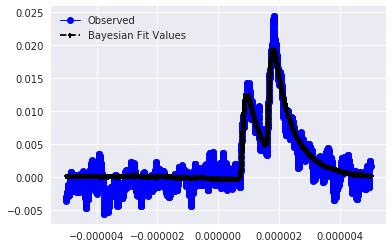

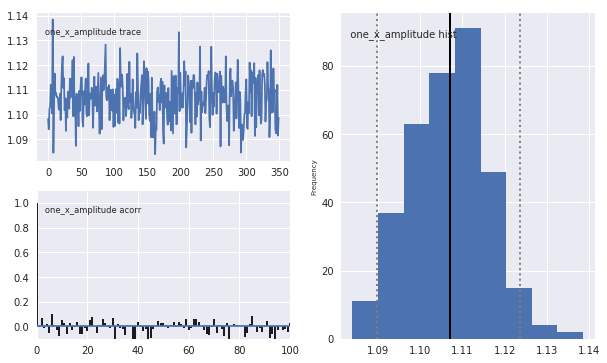

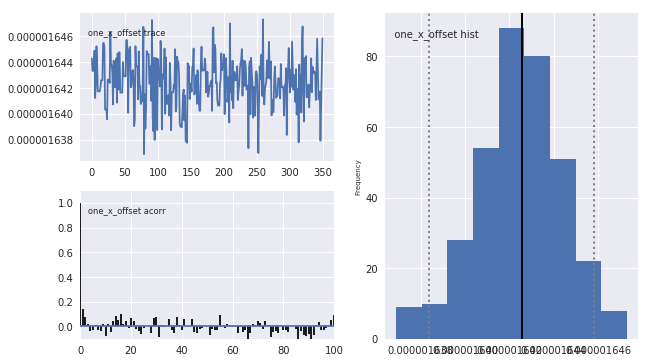

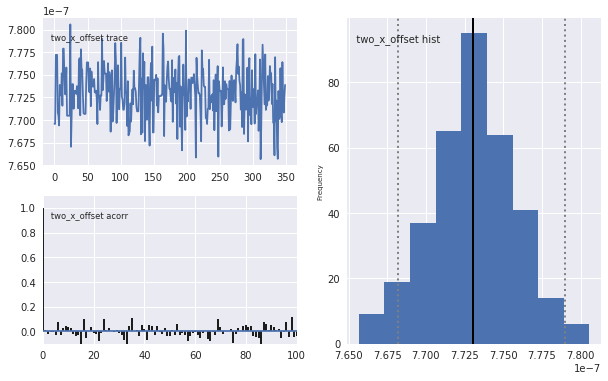

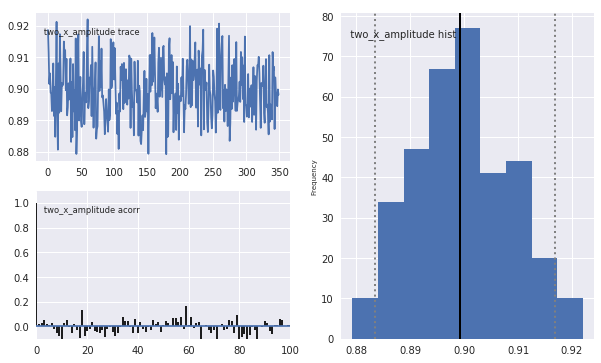

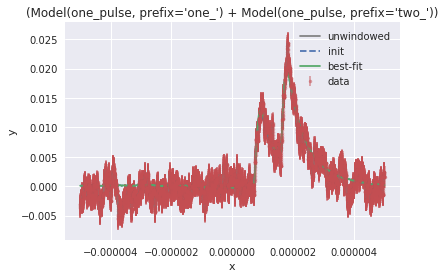

In [18]:
reload(pf7)
a, b, c = pf7.testcw(filelist_cont[mask_2ph_cont][1],
           t_initial,
           t_final,
          two_pulse_fit,
           one_pulse=one_pulse,
          sigma0=sigma0,    # signal noise
                                   amp_mu=amp_mu,
                                   amp_tau=amp_tau,
                                   amp_a=amp_a,
                                   amp_b=amp_b, 
          sampling=1.2e4,
          burn=5e3,
          thin=20,
          height_th=height_th)

In [39]:
# extract fit results, initial and final, from lmfit object.
# works in pandas which concats diff datatypes easily.
def results_extr(r):
    """
    Extracts initial, final values from lmfit object.
    """
    results_summary=[]
    keys=[]
    for i,key in enumerate(r.init_values.keys()):
        results_summary.append(float(r.init_values.values()[i]))
        keys.append(key+'_init')
    for i,key in enumerate(r.best_values.keys()):
        results_summary.append(r.best_values.values()[i])
        keys.append(key+'_fitted')
    return results_summary, keys

def results_packager(results_summary, keys, fname, mcmc_flag, unequal_edges):
    """
    Concatinates fit results and other flags together in a pandas row.
    """
#     r,keys = results_extr(a)
    r = np.array(results_summary).reshape(1,8)
    keys = np.array(keys).reshape(8,)
    p = pandas.DataFrame(r,columns=keys)
    q = pandas.DataFrame([[fname, mcmc_flag, unequal_edges]],
                         columns=['fname','mcmc_flag','unequal_edges'])
    return pandas.concat([q,p], axis=1)

def results_saver(outfile, results_summary, keys, fname, mcmc_flag, unequal_edges):
    """
    Append new pandas row to an outfile.
    """
    with open(outfile,'a+') as f:
        if not f.read(1):
            print 'creating new file'
            header = True
        else:
            header = False
        results_packager(results_summary, keys, fname, mcmc_flag, unequal_edges).to_csv(f,header=header)
    f.close()

In [40]:
from timeit import Timer
t = Timer(lambda: results_packager(*results_extr(a),fname='fname',mcmc_flag=True,unequal_edges=False))
print t.timeit(number=1)
# df = results_packager(*results_extr(a),fname='fname',mcmc_flag=True,unequal_edges=False)
# (df['one_x_offset_init']-df['two_x_offset_init'])*1e9

0.009761095047


In [41]:
# Troubleshoot discriminator
reload(pd)
t,s = hpa.trace_extr(filelist_cont[mask_2ph_cont][20])
[mask, clamp, edges, left_edges, right_edges] = pd.discriminator(t,s, 
                                                                  dt_left=300e-9,dt_right=1400e-9, 
                                                                  height_th=height_th, 
                                                                  Plot=False, 
                                                                  method=2)
window = mask&clamp
plt.figure()
plt.plot(t,s)
# 
plt.scatter(t[window],s[window],color='red')
# plt.axvline(t[left_edges[0]])
# plt.axvline(t[right_edges[-1]])
# t_left = t[left_edges[0]]
# t_right = t[right_edges[-1]]
# plt.scatter(t[(window)&(t_left<t)&(t<t_right)],
#             s[(window)&(t_left<t)&(t<t_right)],color='green')
print [mask, clamp, edges, left_edges, right_edges]

TypeError: trace_extr() takes at least 2 arguments (1 given)

# MCMC Optimisation

### Step 5.1: edit precision desired through q, r

In [ ]:
# Perform Diagnostic on a sample trace to determine the recommended fitting params
pymc_diagnostic = pymc.raftery_lewis(b, q=0.025, r=0.01);
pymc_diagnostic
# print np.array([pymc_diagnostic[i] for i in pymc_diagnostic.keys()[1:]])

# MultiProcess 2 photon traces 

### Step 6: 
### * Edit t_initial and t_final windows to save convergence time - warning: too short a time period will affect background estimation accuracy!
### * Update sampling, burn and thin based on optimised parameters in Step 5

In [42]:
# Initialise telegram to message progress
from telegram.bot import Bot
uid='304462759'
token='351459283:AAH5Gyojsh69DtecyxFuCm_Rha4i8QNMSZo'
sender_bot=Bot(token=token)
sender_bot.sendMessage(chat_id=uid,text='testing')

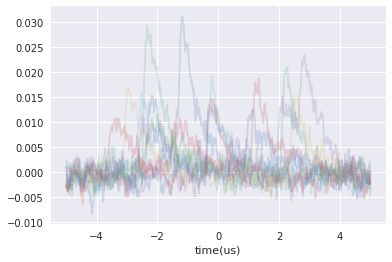

In [46]:
hpa.pplot(filelist_cont[mask_2ph_cont][:100],height_th)

In [19]:
reload(hpa)
import multiprocess as mp
from multiprocess import Pool
tasks = np.array(filelist_cont[mask_2ph_cont])
# tasks = directories[0]+fnames+'.trc'
counter = mp.Value('i',0)
has_header = mp.Value("b", True)
p = Pool(24)

def fit_two_poolable(file):
    try:
        fname = file.split('/')[-1].split('.trc')[0]
        time, signal = hpa.trace_extr(file, h_th=height_th, t_initial=None, t_final=None)
        result, mcmc_flag, unequal_edges = pf7.fit_two_cw(time,signal,
                                                        two_pulse_fit,
                                                        one_pulse=one_pulse,
                                                        sigma0=sigma0,    # signal noise
                                                           amp_mu=amp_mu, 
                                                           amp_tau=amp_tau, 
                                                           amp_a=amp_a, 
                                                           amp_b=amp_b, 
                                                      sampling=1e4,
                                                      burn=20,
                                                      thin=30,
                                                      height_th=height_th)
        # Extract results
        results_summary, keys = results_extr(result)
        df = results_packager(results_summary, keys, fname, mcmc_flag, unequal_edges)
        # Sends Telegram Message to Update Status
        counter.value+=1
        times_toupdate = 20
        text_tosend = '\nProcess finished:'+ '%.1f'%(counter.value/len(tasks)*100) + "%"
        print text_tosend
        try:
            if counter.value % int(len(tasks)/times_toupdate) == 0:
                sender_bot.sendMessage(chat_id=uid,text=text_tosend)
        except:
            pass
        
        # Extracts useful data for saving
        return df
    except:
        print 'exception' #if file is corrupt

In [277]:
def run_fit_two_poolable(outfile,tasks):
    """
    Append new pandas row to an outfile.
    """
    counter = mp.Value('i',0)
    with open(outfile,'a+') as f:
        df = p.map(fit_two_poolable,tasks[0:1])
        df[0].to_csv(f,header=True)
        for df in p.imap(fit_two_poolable,tasks[1:]):
            try:
                df.to_csv(f,header=False)
            except:
                pass

In [278]:
run_fit_two_poolable(results_directory+'results_indv_amps.csv',tasks)

In [60]:
results_csv = pandas.read_csv(results_directory+'results.csv')

In [279]:
results_csv[:5]

,Unnamed: 0,fname,mcmc_flag,unequal_edges,one_x_offset_init,one_amplitude_init,two_amplitude_init,two_x_offset_init,one_x_offset_fitted,one_amplitude_fitted,two_amplitude_fitted,two_x_offset_fitted
0,0,C2doubles00051,True,False,-1.407769e-06,0.955478,1.010712,-0.000001,-1.411767e-06,0.896733,1.080768,-0.000001
1,0,C2doubles00057,True,False,7.720665e-07,0.902297,1.098318,0.000002,7.732177e-07,0.898710,1.107171,0.000002
2,0,C2doubles00060,False,False,3.060000e-07,0.959242,0.959242,0.000002,3.060000e-07,0.959242,0.959242,0.000002
3,0,C2doubles00121,False,False,-3.740000e-07,0.959242,0.959242,0.000002,-3.740000e-07,0.959242,0.959242,0.000002
4,0,C2doubles00134,False,False,-1.729000e-06,0.959242,0.959242,0.000003,-1.729000e-06,0.959242,0.959242,0.000003


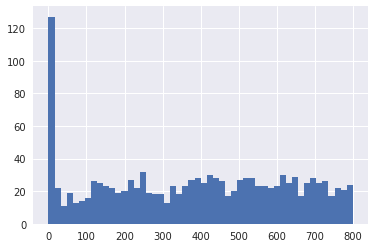

In [275]:
plt.hist(np.abs(results_csv['one_x_offset_init']*1e9-results_csv['two_x_offset_init']*1e9)\
         [(results_csv['mcmc_flag']==True)\
          &(results_csv['unequal_edges']==False)
          &((results_csv['one_amplitude_init']>0)\
            &(results_csv['two_amplitude_init']>0))],
         50,
         range=[0,800]);

In [270]:
g2 = np.abs(results_csv['one_x_offset_init']*1e9-results_csv['two_x_offset_init']*1e9)
mask = (g2 < 10)\
# &(g2 < 50)
fnames = np.array(results_csv[mask]['fname'])
print fnames[-20:-1]

['C2doubles_more_more23710' 'C2doubles_more_more24277'
 'C2doubles_more_more25294' 'C2doubles_more_more25355'
 'C2doubles_more_more37208' 'C2doubles_more_more38710'
 'C2doubles_more_more44472' 'C2doubles_more_more45390'
 'C2doubles_more_more46533' 'C2doubles_more_more47131'
 'C2doubles_more_more47212' 'C2doubles_more_more49620'
 'C2doubles_more_more53519' 'C2doubles_more_more57660'
 'C2doubles_more_more58336' 'C2doubles_more_more62397'
 'C2doubles_more_more64317' 'C2doubles_more_more66409'
 'C2doubles_more_more66912']


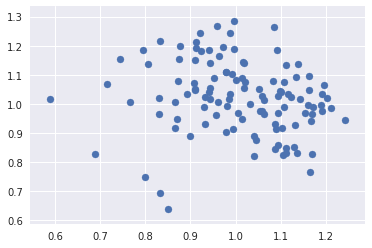

In [250]:
plt.figure()
plt.scatter(results_csv['one_amplitude_init'][mask],results_csv['two_amplitude_init'][mask])

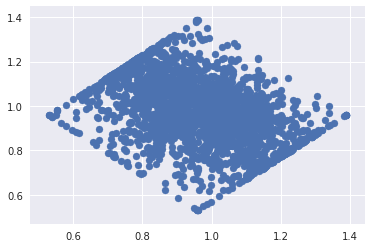

In [188]:
plt.figure()
plt.scatter(results_csv['one_amplitude_init'][~mask],results_csv['two_amplitude_init'][~mask])

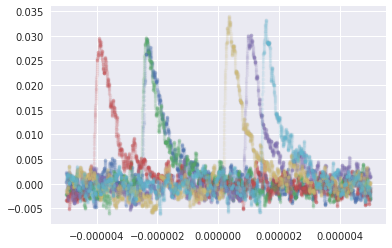

In [251]:
plt.figure()
for i in np.arange(6):
    for j in np.arange(len(directories)):
        try:
            plt.plot(*hpa.trace_extr(directories[j]+fnames[i]+'.trc',h_th=height_th),alpha=0.1, marker='.')
        except:
            pass

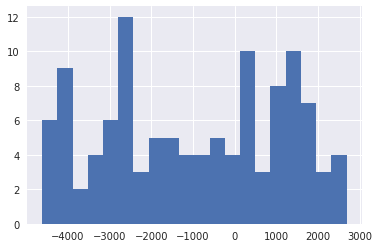

In [252]:
plt.figure()
plt.hist(results_csv[mask]['one_x_offset_init']*1e9,20);

### Check Results / Pickled Results

In [219]:
processed_cont = pf.extract(results_formatted_cont)

In [12]:
print results_formatted_cont[0].init_values
print results_formatted_cont[0].values

{'one_x_offset': -4.3420628157872983e-06, 'one_amplitude': 1, 'two_amplitude': 1, 'two_x_offset': 1.6499370147473684e-06}
{'one_x_offset': -4.3420628157872983e-06, 'one_amplitude': 0.99045215885822446, 'two_amplitude': 0.87663608712173557, 'two_x_offset': 1.6499370147473684e-06}


In [13]:
one_x_offsets=[]
two_x_offsets=[]
one_amplitudes=[]
two_amplitudes=[]
for i, r in enumerate(results_formatted_cont):
    if mcmc_flags[i]==True:
        one_x_offsets.append(r.init_values['one_x_offset'])
        two_x_offsets.append(r.init_values['two_x_offset'])
        one_amplitudes.append(r.init_values['one_amplitude'])
        two_amplitudes.append(r.init_values['two_amplitude'])
    if mcmc_flags[i]==False:
        one_x_offsets.append(r.values['one_x_offset'])
        two_x_offsets.append(r.values['two_x_offset'])
        one_amplitudes.append(r.values['one_amplitude'])
        two_amplitudes.append(r.values['two_amplitude'])
one_x_offsets=np.array(one_x_offsets)
two_x_offsets=np.array(two_x_offsets)
one_amplitudes=np.array(one_amplitudes)
two_amplitudes=np.array(two_amplitudes)

In [14]:
abs_taus_cont = np.abs(one_x_offsets-two_x_offsets)*1e9

## Absolute Time Separation

(642.15590849227362, 59.603885232692733)
fwhm = 140.367149723


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


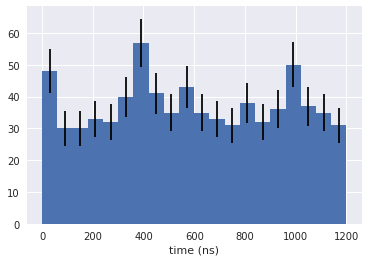

In [15]:
%matplotlib inline
mask_max_amp = np.minimum(one_amplitudes,two_amplitudes)>0.6
freq, bins = np.histogram(abs_taus_cont, 
                          bins=int(1200/60), 
                          range=(0,1200))
bins = bins[:-1]+np.diff(bins)[0]/2

plt.figure('arrival times _cont')
# plt.hist(abs_taus_cont, 20, range=(100,250), align='centre');
plt.bar(bins,freq,align='center',width=np.diff(bins)[0], yerr=np.sqrt(freq))
plt.xlabel('time (ns)')
plt.ylim(0,np.max(freq)*1.2)
# plt.ylim(0, 1000)
# plt.savefig(results_directory+'arrival_times_cont.pdf')
reload(sp)
# sp.FWHM(bins, freq, plot=True)
(m,s) = norm.fit(abs_taus_cont[(abs_taus_cont>550)&(abs_taus_cont<750)])
print (m,s)
print 'fwhm = {}'.format(2.355*s)

## Plot anomalies

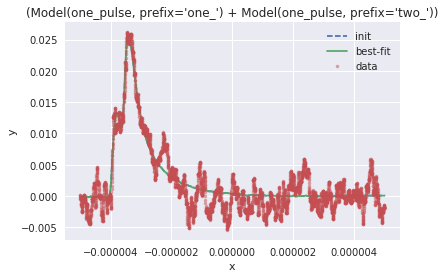

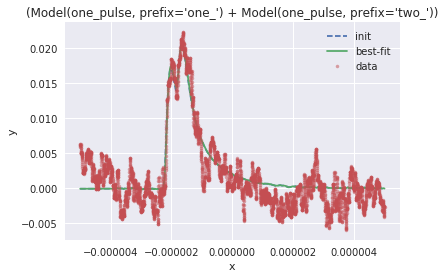

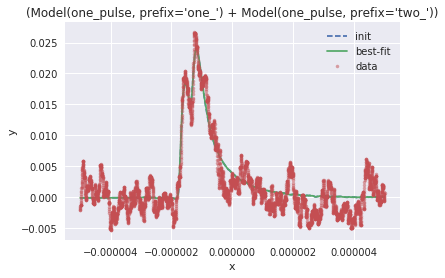

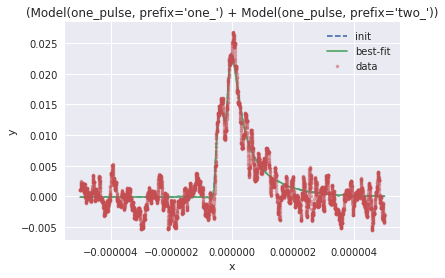

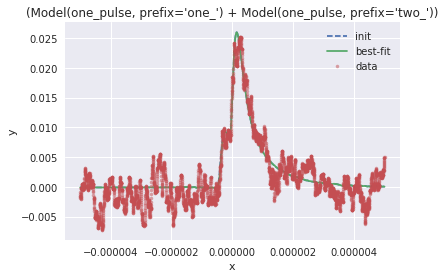

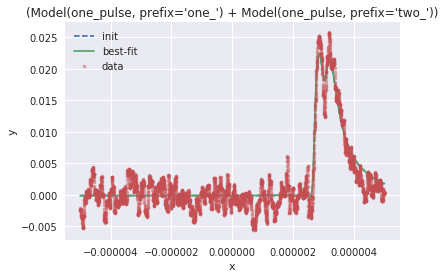

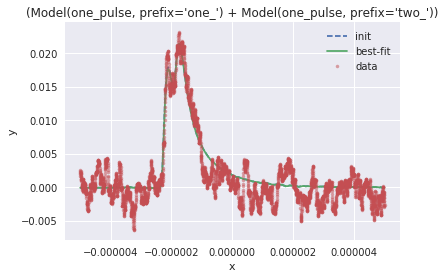

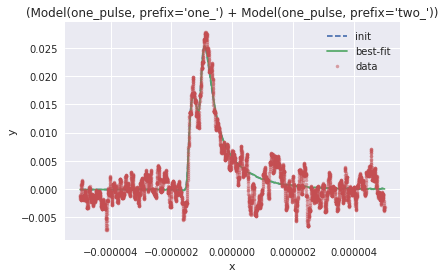

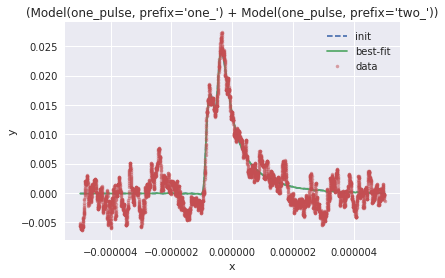

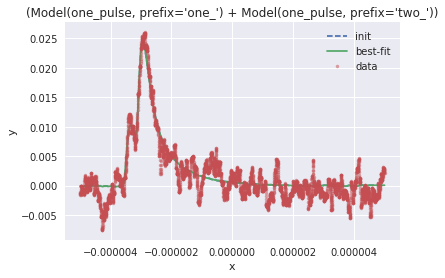

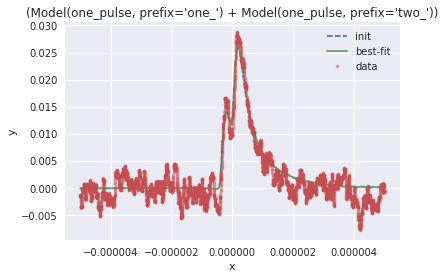

In [75]:
%matplotlib inline
mask = (abs_taus_cont>395)&(abs_taus_cont<405)
# print len(results_formatted_cont)
# print len(mask)
for i in np.arange(np.sum(mask)):
    plt.figure()
    np.array(results_formatted_cont)[mask][i].plot_fit(data_kws={'marker':".",'alpha':0.5})
    plt.savefig('abs_tau_395_to_405_ns_plots'+'/'+str(abs_taus_cont[mask][i])+'.pdf')

## Time Separation

In [16]:
taus_cont = (two_x_offsets-one_x_offsets)*1e9

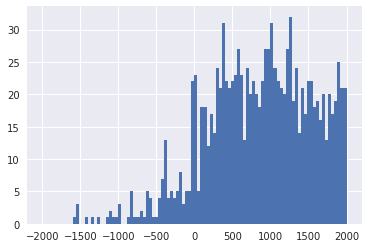

In [17]:
%matplotlib inline
plt.figure()
plt.hist((taus_cont),int(4000/40),range=(-2000,2000));
# plt.ylim(0,200)

## Separation vs Maximum or Sum of Amplitudes

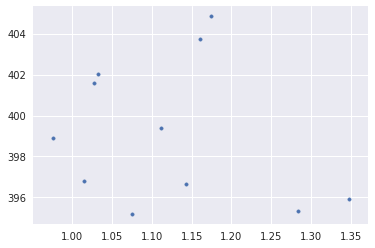

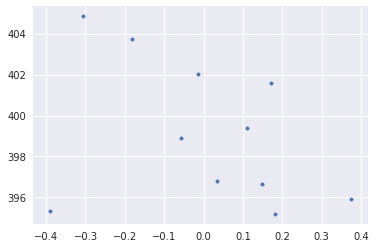

In [56]:
# mask=(taus_cont>0)&(taus_cont<80)

plt.scatter(np.maximum(one_amplitudes, two_amplitudes)[mask], abs_taus_cont[mask], marker='.')
plt.figure()
plt.scatter(((one_amplitudes-two_amplitudes)/(one_amplitudes+two_amplitudes))[mask], 
            abs_taus_cont[mask], 
            marker='.')

caption: 
single photon pulses leaking into 2 photon population caused the spike in 0-50ns bin increase in population 

it's effects decay as tau increases.

## Amplitude 1 vs Amplitude 2

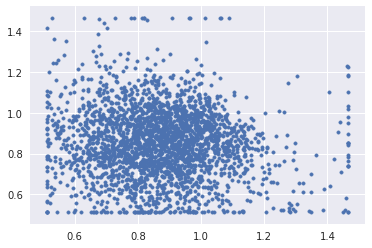

In [18]:
plt.scatter(one_amplitudes,two_amplitudes,marker='.')

## Histogram of Min, Max Ampltudes from Least Squares Fit

(array([  16.,   58.,  243.,  479.,  587.,  412.,   89.,   13.,    3.,   16.]),
 array([ 0.5126331 ,  0.60791876,  0.70320442,  0.79849008,  0.89377574,
         0.9890614 ,  1.08434706,  1.17963272,  1.27491838,  1.37020404,
         1.4654897 ]),
 <a list of 10 Patch objects>)

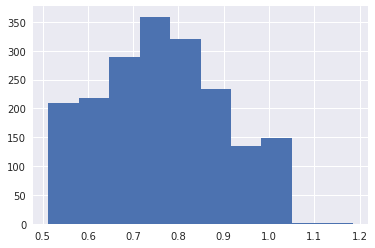

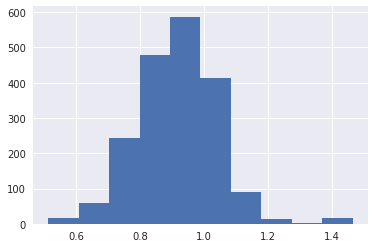

In [19]:
plt.hist(np.minimum(one_amplitudes,two_amplitudes)[~mcmc_flags])
plt.figure();plt.hist(np.maximum(one_amplitudes,two_amplitudes)[~mcmc_flags])

caption: amplitudes remain mostly at default values without change: justifies use of MCMC instead of least squares

## Maximum Amplitude is limited for cases when MCMC is activated

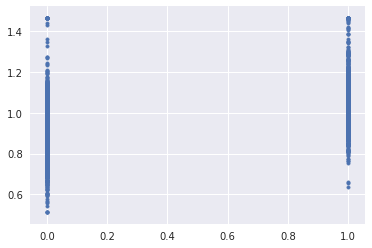

In [104]:
plt.scatter(mcmc_flags, np.maximum(one_amplitudes,two_amplitudes),marker='.')

(0, 80)

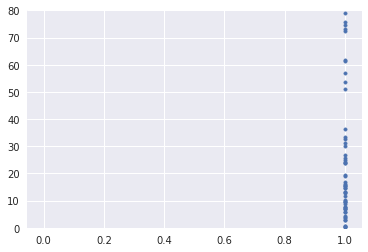

In [115]:
plt.scatter(mcmc_flags, abs_taus_cont, marker='.')
plt.ylim(0,80)

## Plots from MCMC

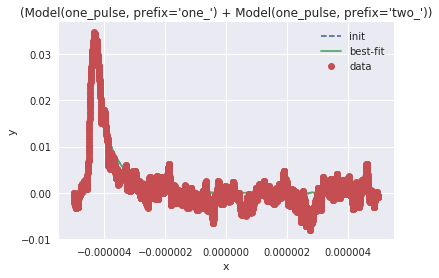

In [122]:
mask = np.minimum(one_amplitudes,two_amplitudes)>0.6
trace = '/home/jianwei_leejw/data/20161116_TES5_20MHz_bwl_diode_n012_height_optimised/continuous_diode/'+\
np.array(fnames)[mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)][0]+'.trc'
np.array(results_formatted_cont)[mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)][0].plot_fit()

caption: single photon pulses activates MCMC fitting since there is only one pulse region. Thus 0.5 amplitude pulses are overrepresented within MCMC fitted pulses.

In [148]:
np.sum([~mask&mcmc_flags&(taus_cont>0)&(taus_cont<20)])

17

In [109]:
def testcw(fname, sampling, burn, thin, height_th, Plot=True):
    result, mcmc_flag, unequal_edges = fit_two_cw(*hpa.trace_extr(fname, 
                                                  t_initial, t_final), 
                            
                                  height_th=height_th, 
                                  sampling=sampling,
                                 burn=burn,
                                 thin=thin,
                                debug=True)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.figure()
        plt.plot(*hpa.trace_extr(fname), label='unwindowed', color='grey')
        result.plot_fit()
        plt.savefig(results_directory+'testmcmccw.pdf')
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
    return result, mcmc_flag, unequal_edges

(-4.7800599153131698e-06, -3.9000599402012695e-06, None)
 [-----------------100%-----------------] 15000 of 15000 complete in 5.8 secPlotting two_x_amplitude
Plotting one_x_offset
Plotting one_x_amplitude
Plotting two_x_offset
[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:   -4.5074e-06 +/- nan      (nan%) (init=-4.513963e-06)
    two_x_offset:   -4.5072e-06 +/- nan      (nan%) (init=-4.500213e-06)
    one_amplitude:   0.85888363 +/- 1.66e+04 (1935076.86%) (init= 0.824722)
    two_amplitude:   0.94526775 +/- 1.66e+04 (1758237.23%) (init= 0.9898061)
[[Correlations]] (unreported correlations are <  0.100)
    C(one_amplitude, two_amplitude)  = -1.000 

arrival time difference = -13.75ns


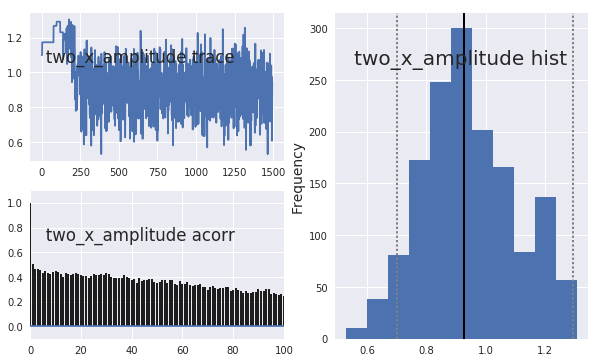

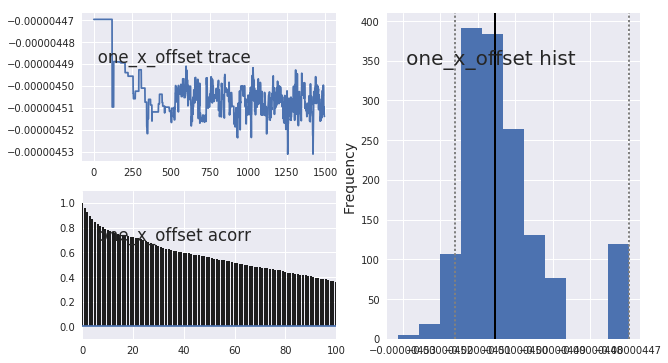

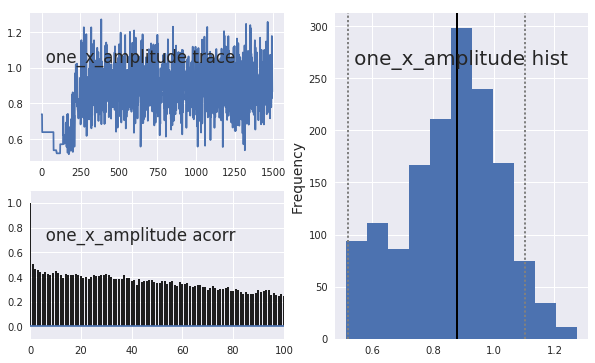

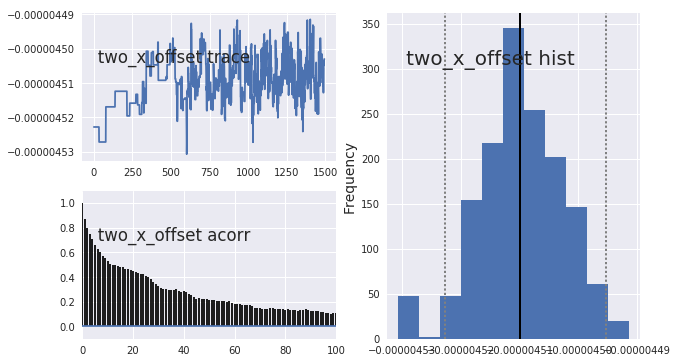

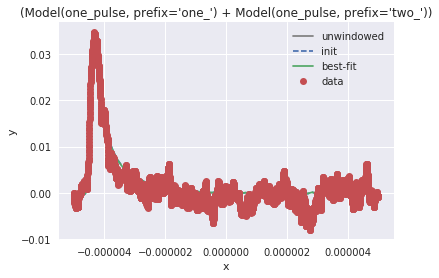

In [152]:
a, b, c = testcw(trace,sampling=1.5e4,burn=40,thin=10,
                height_th=height_th,Plot=True);

### Save a reduced version of the results

In [178]:
# Just extract the amplitudes and offsets from Bayesian or LMfit fits
keys = results_formatted_cont[0].init_values.keys()
dtype = [(key,'float') for key in keys]
results_cont_reduced =[tuple(np.array(r.init_values.values())) for r in results_formatted_cont]
results_cont_reduced = np.array(results_cont_reduced,dtype=dtype)
np.savetxt(results_directory+'results_cont_2nspp_reduced.dat',
           results_cont_reduced, header='\t'.join(results_cont_reduced.dtype.names))

### Load a reduced version of the results

In [ ]:
results = np.genfromtxt(results_directory+'results_cont_reduced.dat', names=True)
plt.figure()
plt.scatter(results['one_amplitude'],results['two_amplitude'])
plt.figure()
plt.hist(results['one_amplitude']-results['two_amplitude']/(results['one_amplitude']+results['two_amplitude']),100);

# Plotting Functions for troubleshooting

In [ ]:
plt.figure()
plt.plot(*hpa.trace_extr(filelist_cont[mask_2ph_cont][(abs_taus_cont>20)&(abs_taus_cont<50)][1]))
plt.xlim(0,2e-6)

In [ ]:
IntResult = np.array(results_cont)[(taus_cont>-60)&(taus_cont<-20)][3]
# IntResult = a #Interesting Result
time = hpa.trace_extr((filelist_cont[0]))[0]
time = time[time>=-2e-6]
signal = IntResult.data[time>=-2e-6]

plt.figure()
plt.xlim(0.2e-6,0.6e-6)
plt.plot(time, signal, label='data')

one_signal = one_pulse(time, IntResult.init_values['one_x_offset'], IntResult.init_values['one_amplitude'])
two_signal = one_pulse(time, IntResult.init_values['two_x_offset'], IntResult.init_values['two_amplitude'])

plt.plot(time,one_signal+two_signal,label='both pulses (mcmc)')
plt.plot(time,one_signal,label='first pulse (mcmc)')
plt.plot(time,two_signal,label='second pulse (mcmc)')
plt.legend()

plt.text(1.75e-6,0.03,IntResult.fit_report(),fontsize=5, va='top', ha='right')
plt.title('Bayesian fitted time difference = {:.2f}ns'\
    .format(np.abs(IntResult.init_values['one_x_offset']-IntResult.init_values['two_x_offset'])*1e9)
)

# Save plot, traces, report
# plt.savefig(results_directory + 'mcmc_fitted_components_cont.pdf')
# np.savetxt(results_directory+'mcmc_fitted_components_cont.dat',
#           zip(time,signal,one_signal,two_signal),
#           header="time\tsignal\tone_signal\ttwo_signal")
# with open("mcmc_fitted_components_cont.txt", "w") as text_file:
#     text_file.write("Purchase Amount: {0}".format(IntResult.fit_report()))

In [ ]:
# traces that fall between 0ns and _cont separation
plt.figure()
[plt.plot(r.data[::10], alpha=0.1) for r in np.array(results_cont)[(taus_cont>-60)&(taus_cont<-50)]];
plt.xlim(110,140)

In [ ]:
# traces that are correctly fitted for _cont separation
plt.figure()
[plt.plot(r.data[::10], alpha=0.1) for r in np.array(results_cont)[(taus_cont>-20)&(taus_cont<0)]];
plt.xlim(110,140)

In [ ]:
def testmcmc_bydata(time, signal, iters, height_th, Plot=True):
    result, result_mcmc = fit_two(time, signal, 
                                                  
                                  height_th=height_th, 
                                  sampling=iters)
    # pymc.gelman_rubin() #https://pymc-devs.github.io/pymc/modelchecking.html
    if Plot:
        plt.plot(time, signal, label='unwindowed')
        plt.plot(result_mcmc.time, result_mcmc.signal, 'b', marker='o', ls='-', lw=1, label='Observed')
        plt.plot(result_mcmc.time, result_mcmc.mod_two_pulse.value,'k', marker='+', ls='--', ms=5, mew=2, label='Bayesian Fit Values')
        plt.legend()
        print result.fit_report()
        print ('arrival time difference = {:.2f}ns'.\
               format((result.init_values['one_x_offset']-result.init_values['two_x_offset'])*1e9))
        pymc.Matplot.plot(result_mcmc)
    return result, result_mcmc

# a, b = testmcmc_bydata(time, signal,2e4,height_th,Plot=True)

# Load Pickle results

In [151]:
fileObject = open('lmfit_data_cont','r')
PickleObject=pickle.load(fileObject)

<IPython.core.display.Javascript object>


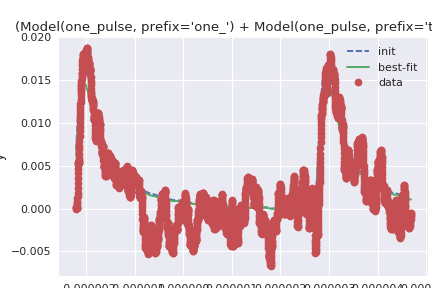

In [168]:
plt.figure()
PickleObject[315][0].plot_fit()

In [ ]:
results_formatted_cont